In [7]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams.update({'font.size': 22})
matplotlib.rcParams.update({'lines.linewidth': 2})
from scipy import stats
from loss import *
from model import FFNN
from utils import set_all_seeds

class pair_dataset(torch.utils.data.Dataset):
  def __init__(self, X, Y):
    self.X = torch.from_numpy(X.astype(np.float32))
    self.Y = torch.from_numpy(Y.astype(np.float32))
  def __len__(self):
    try:
      L = len(self.X)
    except:
      L = self.X.shape[0]
    return L 
  def __getitem__(self, idx):
    return self.X[idx], self.Y[idx]
 

# Sine Dataset

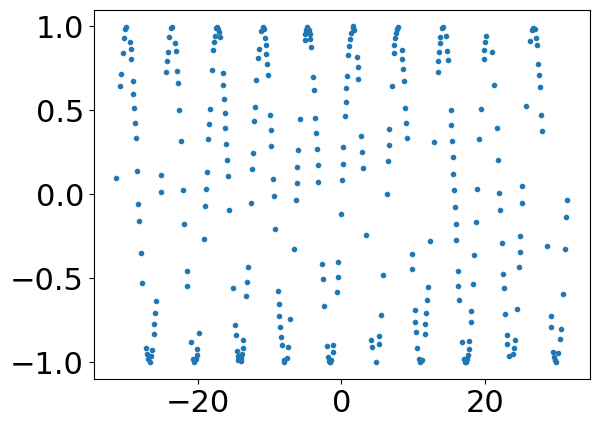

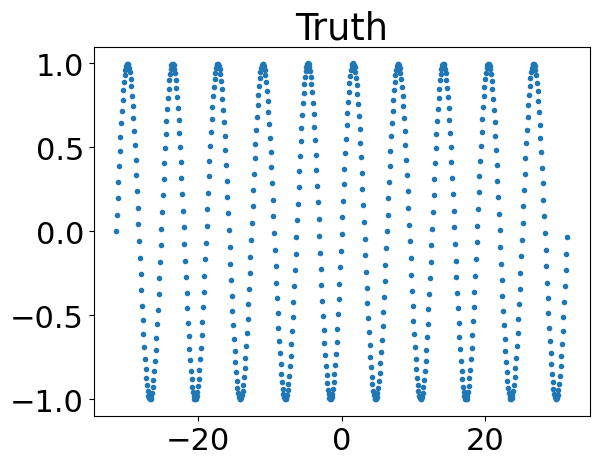

In [2]:
# X = np.arange(-50,50,0.1).reshape([-1,1])
# y = np.sin(X)
# ids = np.random.permutation(X.shape[0])
# np.savez('synthetic_data/sine.npz',X=X, y=y, ids=ids)

tmp = np.load('synthetic_data/sine.npz')
X = tmp['X']
y = tmp['y']
ids = tmp['ids']
teN = int(0.5*X.shape[0])
te_ids = ids[:teN]
tr_ids = ids[teN:]

te_ids = ids[:teN]
tr_ids = ids[teN:]
trX = X[tr_ids]
trY = y[tr_ids]
teX = X[te_ids]
teY = y[te_ids]
plt.figure()
plt.plot(trX, trY, '.')
plt.figure()
plt.plot(X, y, '.')
tr_pair_data = pair_dataset(trX, trY)
te_pair_data = pair_dataset(teX, teY)
BATCH_SIZE = 64
trainloader = torch.utils.data.DataLoader(dataset=tr_pair_data, batch_size=BATCH_SIZE, num_workers=0, shuffle=True, drop_last=True)
testloader = torch.utils.data.DataLoader(dataset=te_pair_data, batch_size=BATCH_SIZE, num_workers=0, shuffle=False, drop_last=False)
# epochs = 300
# milestones = [100, 200]
epochs = 1200
milestones = [300, 600, 900]
plt.title('Truth')
plt.savefig('./figures/pdfs/sin_truth.pdf',format='pdf')



In [3]:
class MLP_tri_head(torch.nn.Module):
    r"""
        An implementation of Multilayer Perceptron (MLP).
    """
    def __init__(self, input_dim=1025, hidden_sizes=(256,), activation='elu', num_classes=64):
        super().__init__()
        self.hidden_sizes = hidden_sizes
        if sum(self.hidden_sizes) > 0: # multi-layer model
            layers = []
            for i in range(len(hidden_sizes)):
                layers.append(torch.nn.Linear(input_dim, hidden_sizes[i])) 
                if activation=='relu':
                  layers.append(torch.nn.ReLU())
                elif activation=='elu':
                  layers.append(torch.nn.ELU())
                else:
                  pass 
                input_dim = hidden_sizes[i]
            self.layers = torch.nn.Sequential(*layers)
        self.fc_1 = FFNN(input_dim, hidden_sizes, num_classes=num_classes)
        self.fc_2 = FFNN(input_dim, hidden_sizes, num_classes=num_classes)
        self.fc_3 = FFNN(input_dim, hidden_sizes, num_classes=num_classes)

    def forward(self, x):
        """forward pass"""
        if sum(self.hidden_sizes) > 0:
            x = self.layers(x)
        pred_mean,_ = self.fc_1(x)
        pred_var,_ = self.fc_2(x)
        pred_pearson,_ = self.fc_3(x)
        return pred_mean, pred_var, pred_pearson, x 

    def predict(self, pred_mean, pred_var, pred_pearson):
        eps = 1e-7
        mean_est = pred_mean.mean(dim=0)
        std_est = torch.clip(pred_var.std(dim=0), min=eps)
        pear_mean_est, pear_std_est = pred_pearson.mean(dim=0), torch.clip(pred_pearson.std(dim=0), min=eps)
        pred = (pred_pearson - pear_mean_est)/pear_std_est
        pred = pred * std_est + mean_est
        return pred


In [ ]:
lr = 0.01
decay = 0


seeds = [1,2,3,4,5]
preds_GARM = []


for seed in seeds:
    set_all_seeds(seed)
    model = MLP_tri_head(input_dim=X.shape[-1], hidden_sizes=tuple([100]*3), num_classes=1)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=decay)
    scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=milestones, gamma=0.1)
    gar_mean = GAR_mean()
    for epoch in range(epochs):
        epoch_loss = 0 
        pred = []
        truth = []
        for idx, data in enumerate(trainloader):
            optimizer.zero_grad()
            tr_X, tr_Y = data[0], data[1]
            pred_Y_mean, pred_Y_var, pred_Y_pearson, feat = model(tr_X)
            pred_Y = model.predict(pred_Y_mean, pred_Y_var, pred_Y_pearson)
            pred.append(pred_Y.cpu().detach().numpy())
            truth.append(tr_Y.cpu().detach().numpy())
            
               
            loss_mean = gar_mean(pred_Y_mean, tr_Y)
            loss_var = GAR_var(pred_Y_var, tr_Y)
            loss_pearson = GAR_pearson(pred_Y_pearson, tr_Y)
            loss_final = gar_mean(pred_Y, tr_Y) 
            loss = loss_mean + loss_var + loss_pearson + loss_final
            
            epoch_loss += loss.cpu().detach().numpy()
            loss.backward()
            optimizer.step()
        epoch_loss /= idx        
        if epoch % 10 == 0:
            pred = np.concatenate(pred, axis=0)
            truth = np.concatenate(truth, axis=0)
            tr_MAE = np.abs(pred-truth).mean()
            tr_RMSE = ((pred-truth)**2).mean()**0.5
            tr_pear = np.corrcoef(truth, pred, rowvar=False)[0,1]
            tr_spear = stats.spearmanr(truth, pred)
            print('Epoch=%s, train_MAE=%.4f, train_RMSE=%.4f, train_Pearson=%.4f, train_Spearman=%.4f, lr=%.4f'%(epoch, tr_MAE, tr_RMSE, tr_pear, tr_spear.statistic, scheduler.get_last_lr()[0]))
        pred = []
        truth = []
        if epoch % 10 == 0:
            for idx, data in enumerate(testloader):
                te_X, te_Y = data[0], data[1]
                pred_Y_mean, pred_Y_var, pred_Y_pearson, feat = model(te_X)
                pred_Y = model.predict(pred_Y_mean, pred_Y_var, pred_Y_pearson)
                pred.append(pred_Y.cpu().detach().numpy())
                truth.append(te_Y.cpu().detach().numpy())  
            pred = np.concatenate(pred, axis=0)
            truth = np.concatenate(truth, axis=0)
            test_MAE = np.abs(pred-truth).mean()
            test_RMSE = ((pred-truth)**2).mean()**0.5
            test_pear = np.corrcoef(truth, pred, rowvar=False)[0,1]
            test_spear = stats.spearmanr(truth, pred)
            print('test_MAE=%.4f, test_RMSE=%.4f, test_Pearson=%.4f, test_Spearman=%.4f'%(test_MAE, test_RMSE, test_pear, test_spear.statistic))
        scheduler.step()

    print(te_X.shape)
    print(torch.from_numpy(X).shape)
    pred_Y_mean, pred_Y_var, pred_Y_pearson, feat = model(torch.from_numpy(X).to(torch.float32))
    pred_Y = model.predict(pred_Y_mean, pred_Y_var, pred_Y_pearson)
    plt.figure()
    plt.plot(X, y, '.', label='truth')
    plt.plot(X, pred_Y.cpu().detach().numpy(), 'o', label='GARM')
    plt.legend()


    plt.figure()
    plt.plot(X, y/y.std(), label='truth')
    plt.legend()

    plt.figure()
    pred_Y = pred_Y.cpu().detach().numpy()
    plt.plot(X, pred_Y/pred_Y.std(), label='GARM')
    plt.legend()

    preds_GARM.append(pred_Y)
    
preds_GARM = np.concatenate(preds_GARM, axis=1)

In [ ]:
lr = 0.01
decay = 0


seeds = [1,2,3,4,5]
preds_GAR_1 = []

alpha = 1.0

for seed in seeds:
    set_all_seeds(seed)
    loss_GAR = GAR(alpha = alpha)
    model = FFNN(input_dim=X.shape[-1], hidden_sizes=tuple([100]*6), num_classes=1)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=decay)
    scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=milestones, gamma=0.1)

    for epoch in range(epochs):
        epoch_loss = 0 
        pred = []
        truth = []
        ratio = epoch/epochs
        for idx, data in enumerate(trainloader):
            optimizer.zero_grad()
            tr_X, tr_Y = data[0], data[1]
            pred_Y, _ = model(tr_X)
            pred.append(pred_Y.cpu().detach().numpy())
            truth.append(tr_Y.cpu().detach().numpy())
            
               
            loss = loss_GAR(pred_Y, tr_Y)
            
            epoch_loss += loss.cpu().detach().numpy()
            loss.backward()
            optimizer.step()
        epoch_loss /= idx
        if epoch % 10 == 0:
            pred = np.concatenate(pred, axis=0)
            truth = np.concatenate(truth, axis=0)
            tr_MAE = np.abs(pred-truth).mean()
            tr_RMSE = ((pred-truth)**2).mean()**0.5
            tr_pear = np.corrcoef(truth, pred, rowvar=False)[0,1]
            tr_spear = stats.spearmanr(truth, pred)
            print('Epoch=%s, train_MAE=%.4f, train_RMSE=%.4f, train_Pearson=%.4f, train_Spearman=%.4f, lr=%.4f'%(epoch, tr_MAE, tr_RMSE, tr_pear, tr_spear.statistic, scheduler.get_last_lr()[0]))
        pred = []
        truth = []
        for idx, data in enumerate(testloader):
            te_X, te_Y = data[0], data[1]
            pred_Y, _ = model(te_X)
            pred.append(pred_Y.cpu().detach().numpy())
            truth.append(te_Y.cpu().detach().numpy())
        if epoch % 10 == 0:
            pred = np.concatenate(pred, axis=0)
            truth = np.concatenate(truth, axis=0)
            test_MAE = np.abs(pred-truth).mean()
            test_RMSE = ((pred-truth)**2).mean()**0.5
            test_pear = np.corrcoef(truth, pred, rowvar=False)[0,1]
            test_spear = stats.spearmanr(truth, pred)
            print('test_MAE=%.4f, test_RMSE=%.4f, test_Pearson=%.4f, test_Spearman=%.4f'%(test_MAE, test_RMSE, test_pear, test_spear.statistic))
        scheduler.step()

    print(te_X.shape)
    print(torch.from_numpy(X).shape)
    pred_Y, _ = model(torch.from_numpy(X).to(torch.float32))
    plt.figure()
    plt.plot(X, y, '.', label='truth')
    plt.plot(X, pred_Y.cpu().detach().numpy(), 'o', label='GAR')
    plt.legend()


    plt.figure()
    plt.plot(X, y/y.std(), label='truth')
    plt.legend()

    plt.figure()
    pred_Y = pred_Y.cpu().detach().numpy()
    plt.plot(X, pred_Y/pred_Y.std(), label='GAR')
    plt.legend()

    preds_GAR_1.append(pred_Y)
    
preds_GAR_1 = np.concatenate(preds_GAR_1, axis=1)

In [ ]:
lr = 0.01
decay = 0


seeds = [1,2,3,4,5]
preds_GAR_2 = []

alpha = 10.0

for seed in seeds:
    set_all_seeds(seed)
    loss_GAR = GAR(alpha = alpha)
    model = FFNN(input_dim=X.shape[-1], hidden_sizes=tuple([100]*6), num_classes=1)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=decay)
    scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=milestones, gamma=0.1)

    for epoch in range(epochs):
        epoch_loss = 0 
        pred = []
        truth = []
        ratio = epoch/epochs
        for idx, data in enumerate(trainloader):
            optimizer.zero_grad()
            tr_X, tr_Y = data[0], data[1]
            pred_Y, _ = model(tr_X)
            pred.append(pred_Y.cpu().detach().numpy())
            truth.append(tr_Y.cpu().detach().numpy())
            
               
            loss = loss_GAR(pred_Y, tr_Y)
            
            epoch_loss += loss.cpu().detach().numpy()
            loss.backward()
            optimizer.step()
        epoch_loss /= idx
        if epoch % 10 == 0:
            pred = np.concatenate(pred, axis=0)
            truth = np.concatenate(truth, axis=0)
            tr_MAE = np.abs(pred-truth).mean()
            tr_RMSE = ((pred-truth)**2).mean()**0.5
            tr_pear = np.corrcoef(truth, pred, rowvar=False)[0,1]
            tr_spear = stats.spearmanr(truth, pred)
            print('Epoch=%s, train_MAE=%.4f, train_RMSE=%.4f, train_Pearson=%.4f, train_Spearman=%.4f, lr=%.4f'%(epoch, tr_MAE, tr_RMSE, tr_pear, tr_spear.statistic, scheduler.get_last_lr()[0]))
        pred = []
        truth = []
        for idx, data in enumerate(testloader):
            te_X, te_Y = data[0], data[1]
            pred_Y, _ = model(te_X)
            pred.append(pred_Y.cpu().detach().numpy())
            truth.append(te_Y.cpu().detach().numpy())
        if epoch % 10 == 0:
            pred = np.concatenate(pred, axis=0)
            truth = np.concatenate(truth, axis=0)
            test_MAE = np.abs(pred-truth).mean()
            test_RMSE = ((pred-truth)**2).mean()**0.5
            test_pear = np.corrcoef(truth, pred, rowvar=False)[0,1]
            test_spear = stats.spearmanr(truth, pred)
            print('test_MAE=%.4f, test_RMSE=%.4f, test_Pearson=%.4f, test_Spearman=%.4f'%(test_MAE, test_RMSE, test_pear, test_spear.statistic))
        scheduler.step()

    print(te_X.shape)
    print(torch.from_numpy(X).shape)
    pred_Y, _ = model(torch.from_numpy(X).to(torch.float32))
    plt.figure()
    plt.plot(X, y, '.', label='truth')
    plt.plot(X, pred_Y.cpu().detach().numpy(), 'o', label='GAR')
    plt.legend()


    plt.figure()
    plt.plot(X, y/y.std(), label='truth')
    plt.legend()

    plt.figure()
    pred_Y = pred_Y.cpu().detach().numpy()
    plt.plot(X, pred_Y/pred_Y.std(), label='GAR')
    plt.legend()

    preds_GAR_2.append(pred_Y)
    
preds_GAR_2 = np.concatenate(preds_GAR_2, axis=1)

In [ ]:
lr = 0.01
decay = 0


seeds = [1,2,3,4,5]
preds_GAR = []

alpha = 0.1

for seed in seeds:
    set_all_seeds(seed)
    loss_GAR = GAR(alpha = alpha)
    model = FFNN(input_dim=X.shape[-1], hidden_sizes=tuple([100]*6), num_classes=1)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=decay)
    scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=milestones, gamma=0.1)

    for epoch in range(epochs):
        epoch_loss = 0 
        pred = []
        truth = []
        ratio = epoch/epochs
        for idx, data in enumerate(trainloader):
            optimizer.zero_grad()
            tr_X, tr_Y = data[0], data[1]
            pred_Y, _ = model(tr_X)
            pred.append(pred_Y.cpu().detach().numpy())
            truth.append(tr_Y.cpu().detach().numpy())
            
               
            loss = loss_GAR(pred_Y, tr_Y)
            
            epoch_loss += loss.cpu().detach().numpy()
            loss.backward()
            optimizer.step()
        epoch_loss /= idx
        if epoch % 10 == 0:
            pred = np.concatenate(pred, axis=0)
            truth = np.concatenate(truth, axis=0)
            tr_MAE = np.abs(pred-truth).mean()
            tr_RMSE = ((pred-truth)**2).mean()**0.5
            tr_pear = np.corrcoef(truth, pred, rowvar=False)[0,1]
            tr_spear = stats.spearmanr(truth, pred)
            print('Epoch=%s, train_MAE=%.4f, train_RMSE=%.4f, train_Pearson=%.4f, train_Spearman=%.4f, lr=%.4f'%(epoch, tr_MAE, tr_RMSE, tr_pear, tr_spear.statistic, scheduler.get_last_lr()[0]))
        pred = []
        truth = []
        for idx, data in enumerate(testloader):
            te_X, te_Y = data[0], data[1]
            pred_Y, _ = model(te_X)
            pred.append(pred_Y.cpu().detach().numpy())
            truth.append(te_Y.cpu().detach().numpy())
        if epoch % 10 == 0:
            pred = np.concatenate(pred, axis=0)
            truth = np.concatenate(truth, axis=0)
            test_MAE = np.abs(pred-truth).mean()
            test_RMSE = ((pred-truth)**2).mean()**0.5
            test_pear = np.corrcoef(truth, pred, rowvar=False)[0,1]
            test_spear = stats.spearmanr(truth, pred)
            print('test_MAE=%.4f, test_RMSE=%.4f, test_Pearson=%.4f, test_Spearman=%.4f'%(test_MAE, test_RMSE, test_pear, test_spear.statistic))
        scheduler.step()

    print(te_X.shape)
    print(torch.from_numpy(X).shape)
    pred_Y, _ = model(torch.from_numpy(X).to(torch.float32))
    plt.figure()
    plt.plot(X, y, '.', label='truth')
    plt.plot(X, pred_Y.cpu().detach().numpy(), 'o', label='GAR')
    plt.legend()


    plt.figure()
    plt.plot(X, y/y.std(), label='truth')
    plt.legend()

    plt.figure()
    pred_Y = pred_Y.cpu().detach().numpy()
    plt.plot(X, pred_Y/pred_Y.std(), label='GAR')
    plt.legend()

    preds_GAR.append(pred_Y)
    
preds_GAR = np.concatenate(preds_GAR, axis=1)

In [ ]:
lr = 0.01
decay = 0
class pearson_loss(torch.nn.Module):
    def __init__(self, device = None):
        super().__init__()
        if not device:
            self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        else:
            self.device = device


    def forward(self, y_pred, y_truth):
        pred_std, truth_std = y_pred.std(dim=0), y_truth.std(dim=0)
        pred_mean, truth_mean = y_pred.mean(dim=0), y_truth.mean(dim=0)
        loss = ((y_pred-pred_mean)/pred_std - (y_truth-truth_mean)/truth_std)**2/2
        return loss.mean()


seeds = [1,2,3,4,5]
preds_Pearson = []

for seed in seeds:
    set_all_seeds(seed)
    loss_MAE = torch.nn.L1Loss()
    loss_pearson = pearson_loss()
    model = FFNN(input_dim=X.shape[-1], hidden_sizes=tuple([100]*6), num_classes=1)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=decay)
    scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=milestones, gamma=0.1)

    for epoch in range(epochs):
        epoch_loss = 0 
        pred = []
        truth = []
        ratio = epoch/epochs
        for idx, data in enumerate(trainloader):
            optimizer.zero_grad()
            tr_X, tr_Y = data[0], data[1]
            pred_Y, _ = model(tr_X)
            pred.append(pred_Y.cpu().detach().numpy())
            truth.append(tr_Y.cpu().detach().numpy())
            
            ploss = loss_pearson(pred_Y, tr_Y)
            beta = ploss.detach()/2
            loss = (1-beta)*loss_MAE(pred_Y, tr_Y) + beta*ploss
            epoch_loss += loss.cpu().detach().numpy()
            loss.backward()
            optimizer.step()
        epoch_loss /= idx
        if epoch % 10 == 0:
            pred = np.concatenate(pred, axis=0)
            truth = np.concatenate(truth, axis=0)
            tr_MAE = np.abs(pred-truth).mean()
            tr_RMSE = ((pred-truth)**2).mean()**0.5
            tr_pear = np.corrcoef(truth, pred, rowvar=False)[0,1]
            tr_spear = stats.spearmanr(truth, pred)
            print('Epoch=%s, train_MAE=%.4f, train_RMSE=%.4f, train_Pearson=%.4f, train_Spearman=%.4f, lr=%.4f'%(epoch, tr_MAE, tr_RMSE, tr_pear, tr_spear.statistic, scheduler.get_last_lr()[0]))
        pred = []
        truth = []
        for idx, data in enumerate(testloader):
            te_X, te_Y = data[0], data[1]
            pred_Y, _ = model(te_X)
            pred.append(pred_Y.cpu().detach().numpy())
            truth.append(te_Y.cpu().detach().numpy())
        if epoch % 10 == 0:
            pred = np.concatenate(pred, axis=0)
            truth = np.concatenate(truth, axis=0)
            test_MAE = np.abs(pred-truth).mean()
            test_RMSE = ((pred-truth)**2).mean()**0.5
            test_pear = np.corrcoef(truth, pred, rowvar=False)[0,1]
            test_spear = stats.spearmanr(truth, pred)
            print('test_MAE=%.4f, test_RMSE=%.4f, test_Pearson=%.4f, test_Spearman=%.4f'%(test_MAE, test_RMSE, test_pear, test_spear.statistic))
        scheduler.step()

    print(te_X.shape)
    print(torch.from_numpy(X).shape)
    pred_Y, _ = model(torch.from_numpy(X).to(torch.float32))
    plt.figure()
    plt.plot(X, y, '.', label='truth')
    plt.plot(X, pred_Y.cpu().detach().numpy(), 'o', label='MAE-Pearson')
    plt.legend()


    plt.figure()
    plt.plot(X, y/y.std(), label='truth')
    plt.legend()

    plt.figure()
    pred_Y = pred_Y.cpu().detach().numpy()
    plt.plot(X, pred_Y/pred_Y.std(), label='MAE-Pearson')
    plt.legend()

    preds_Pearson.append(pred_Y)
    
preds_Pearson = np.concatenate(preds_Pearson, axis=1)

In [ ]:
lr = 0.01
decay = 0

seeds = [1,2,3,4,5]
preds_MAE = []

for seed in seeds:
    set_all_seeds(seed)
    loss_MAE = torch.nn.L1Loss()
    model = FFNN(input_dim=X.shape[-1], hidden_sizes=tuple([100]*6), num_classes=1)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=decay)
    scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=milestones, gamma=0.1)

    for epoch in range(epochs):
        epoch_loss = 0 
        pred = []
        truth = []
        ratio = epoch/epochs
        for idx, data in enumerate(trainloader):
            optimizer.zero_grad()
            tr_X, tr_Y = data[0], data[1]
            pred_Y, _ = model(tr_X)
            pred.append(pred_Y.cpu().detach().numpy())
            truth.append(tr_Y.cpu().detach().numpy())
            
            loss = loss_MAE(pred_Y, tr_Y)
            
            epoch_loss += loss.cpu().detach().numpy()
            loss.backward()
            optimizer.step()
        epoch_loss /= idx
        if epoch % 10 == 0:
            pred = np.concatenate(pred, axis=0)
            truth = np.concatenate(truth, axis=0)
            tr_MAE = np.abs(pred-truth).mean()
            tr_RMSE = ((pred-truth)**2).mean()**0.5
            tr_pear = np.corrcoef(truth, pred, rowvar=False)[0,1]
            tr_spear = stats.spearmanr(truth, pred)
            print('Epoch=%s, train_MAE=%.4f, train_RMSE=%.4f, train_Pearson=%.4f, train_Spearman=%.4f, lr=%.4f'%(epoch, tr_MAE, tr_RMSE, tr_pear, tr_spear.statistic, scheduler.get_last_lr()[0]))
        pred = []
        truth = []
        for idx, data in enumerate(testloader):
            te_X, te_Y = data[0], data[1]
            pred_Y, _ = model(te_X)
            pred.append(pred_Y.cpu().detach().numpy())
            truth.append(te_Y.cpu().detach().numpy())
        if epoch % 10 == 0:
            pred = np.concatenate(pred, axis=0)
            truth = np.concatenate(truth, axis=0)
            test_MAE = np.abs(pred-truth).mean()
            test_RMSE = ((pred-truth)**2).mean()**0.5
            test_pear = np.corrcoef(truth, pred, rowvar=False)[0,1]
            test_spear = stats.spearmanr(truth, pred)
            print('test_MAE=%.4f, test_RMSE=%.4f, test_Pearson=%.4f, test_Spearman=%.4f'%(test_MAE, test_RMSE, test_pear, test_spear.statistic))
        scheduler.step()

    print(te_X.shape)
    print(torch.from_numpy(X).shape)
    pred_Y, _ = model(torch.from_numpy(X).to(torch.float32))
    plt.figure()
    plt.plot(X, y, '.', label='truth')
    plt.plot(X, pred_Y.cpu().detach().numpy(), 'o', label='MAE')
    plt.legend()


    plt.figure()
    plt.plot(X, y/y.std(), label='truth')
    plt.legend()

    plt.figure()
    pred_Y = pred_Y.cpu().detach().numpy()
    plt.plot(X, pred_Y/pred_Y.std(), label='MAE')
    plt.legend()

    preds_MAE.append(pred_Y)
    
preds_MAE = np.concatenate(preds_MAE, axis=1)

In [ ]:
lr = 0.01
decay = 0

seeds = [1,2,3,4,5]
preds_MSE = []

for seed in seeds:
    set_all_seeds(seed)
    loss_MSE = torch.nn.MSELoss()
    model = FFNN(input_dim=X.shape[-1], hidden_sizes=tuple([100]*6), num_classes=1)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=decay)
    scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=milestones, gamma=0.1)

    for epoch in range(epochs):
        epoch_loss = 0 
        pred = []
        truth = []
        ratio = epoch/epochs
        for idx, data in enumerate(trainloader):
            optimizer.zero_grad()
            tr_X, tr_Y = data[0], data[1]
            pred_Y, _ = model(tr_X)
            pred.append(pred_Y.cpu().detach().numpy())
            truth.append(tr_Y.cpu().detach().numpy())
            
            loss = loss_MSE(pred_Y, tr_Y)
            
            epoch_loss += loss.cpu().detach().numpy()
            loss.backward()
            optimizer.step()
        epoch_loss /= idx
        if epoch % 10 == 0:
            pred = np.concatenate(pred, axis=0)
            truth = np.concatenate(truth, axis=0)
            tr_MAE = np.abs(pred-truth).mean()
            tr_RMSE = ((pred-truth)**2).mean()**0.5
            tr_pear = np.corrcoef(truth, pred, rowvar=False)[0,1]
            tr_spear = stats.spearmanr(truth, pred)
            print('Epoch=%s, train_MAE=%.4f, train_RMSE=%.4f, train_Pearson=%.4f, train_Spearman=%.4f, lr=%.4f'%(epoch, tr_MAE, tr_RMSE, tr_pear, tr_spear.statistic, scheduler.get_last_lr()[0]))
        pred = []
        truth = []
        for idx, data in enumerate(testloader):
            te_X, te_Y = data[0], data[1]
            pred_Y, _ = model(te_X)
            pred.append(pred_Y.cpu().detach().numpy())
            truth.append(te_Y.cpu().detach().numpy())
        if epoch % 10 == 0:
            pred = np.concatenate(pred, axis=0)
            truth = np.concatenate(truth, axis=0)
            test_MAE = np.abs(pred-truth).mean()
            test_RMSE = ((pred-truth)**2).mean()**0.5
            test_pear = np.corrcoef(truth, pred, rowvar=False)[0,1]
            test_spear = stats.spearmanr(truth, pred)
            print('test_MAE=%.4f, test_RMSE=%.4f, test_Pearson=%.4f, test_Spearman=%.4f'%(test_MAE, test_RMSE, test_pear, test_spear.statistic))
        scheduler.step()

    print(te_X.shape)
    print(torch.from_numpy(X).shape)
    pred_Y, _ = model(torch.from_numpy(X).to(torch.float32))
    plt.figure()
    plt.plot(X, y, '.', label='truth')
    plt.plot(X, pred_Y.cpu().detach().numpy(), 'o', label='MSE')
    plt.legend()


    plt.figure()
    plt.plot(X, y/y.std(), label='truth')
    plt.legend()

    plt.figure()
    pred_Y = pred_Y.cpu().detach().numpy()
    plt.plot(X, pred_Y/pred_Y.std(), label='MSE')
    plt.legend()

    preds_MSE.append(pred_Y)
    
preds_MSE = np.concatenate(preds_MSE, axis=1)

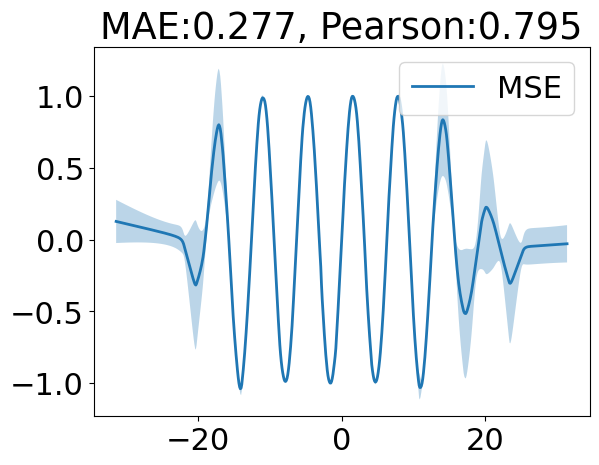

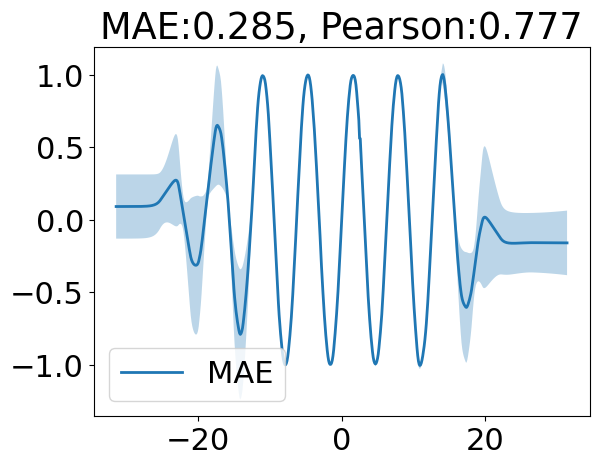

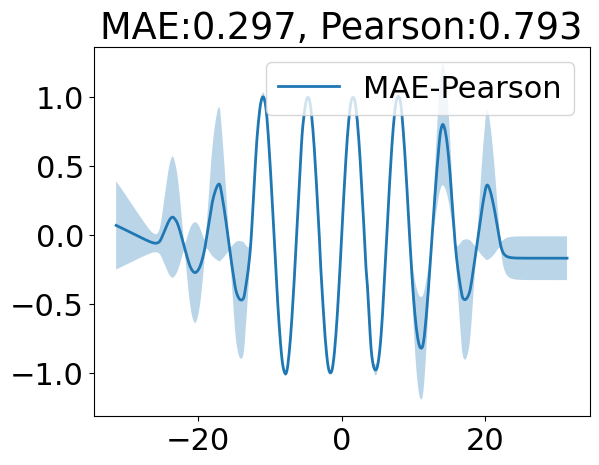

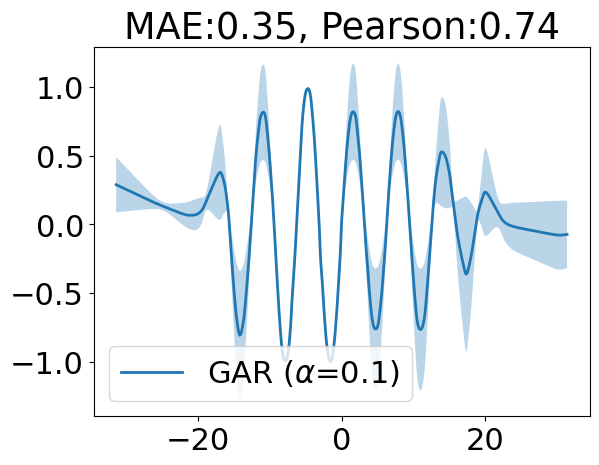

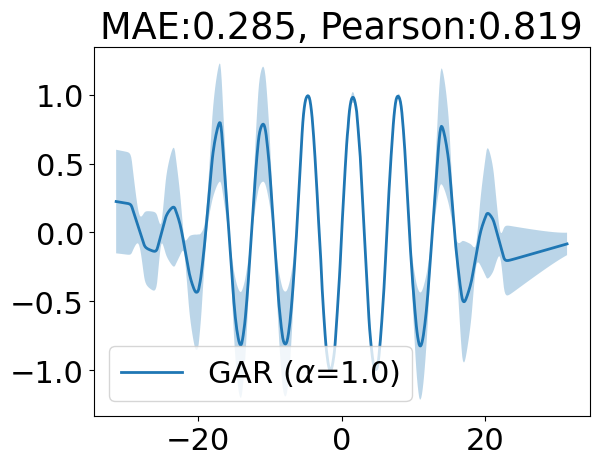

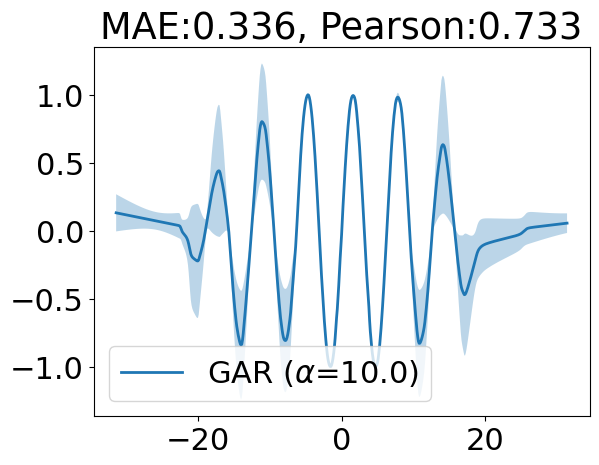

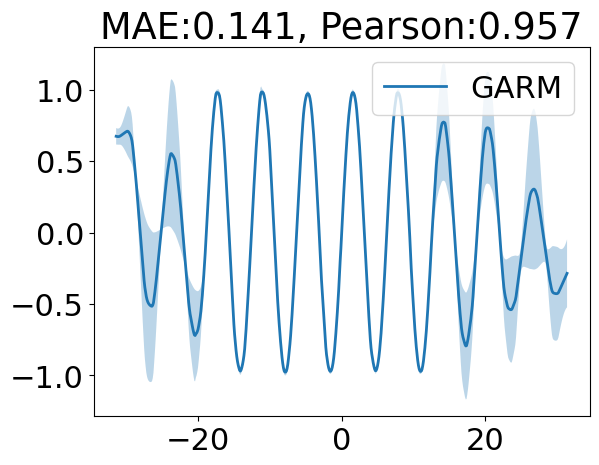

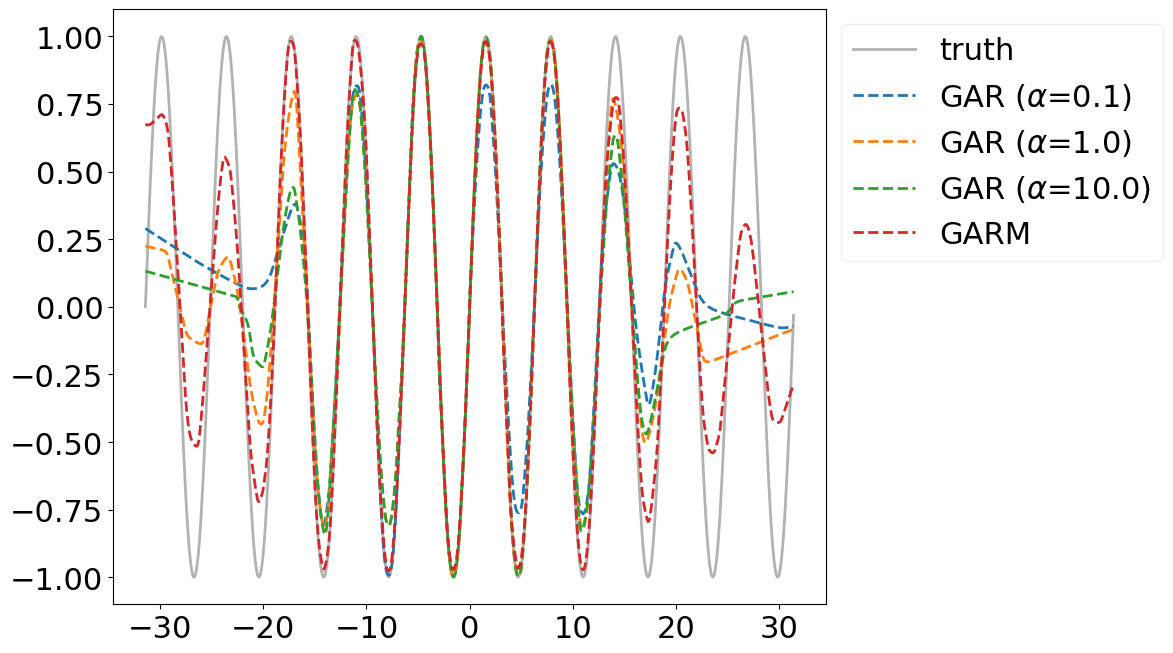

In [16]:

mean_MSE = preds_MSE.mean(axis=1)
std_MSE = preds_MSE.std(axis=1)
mae = np.abs(mean_MSE[te_ids] - np.squeeze(y)[te_ids]).mean()
pear = np.corrcoef(np.squeeze(y)[te_ids], mean_MSE[te_ids], rowvar=False)[0,1]
plt.figure()
plt.plot(X.squeeze(), mean_MSE, label='MSE')
plt.fill_between(X.squeeze(),mean_MSE-std_MSE, mean_MSE+std_MSE, alpha=0.3)
plt.legend()
plt.title('MAE:'+str(np.round(mae, 3))+', Pearson:'+str(np.round(pear, 3)))
plt.savefig('./figures/pdfs/synthetic/sin_MSE.pdf',format='pdf')


mean_MAE = preds_MAE.mean(axis=1)
std_MAE = preds_MAE.std(axis=1)
mae = np.abs(mean_MAE[te_ids] - np.squeeze(y)[te_ids]).mean()
pear = np.corrcoef(np.squeeze(y)[te_ids], mean_MAE[te_ids], rowvar=False)[0,1]
plt.figure()
plt.plot(X.squeeze(), mean_MAE, label='MAE')
plt.fill_between(X.squeeze(),mean_MAE-std_MAE, mean_MAE+std_MAE, alpha=0.3)
plt.legend()
plt.title('MAE:'+str(np.round(mae, 3))+', Pearson:'+str(np.round(pear, 3)))
plt.savefig('./figures/pdfs/synthetic/sin_MAE.pdf',format='pdf')


mean_APearson = preds_Pearson.mean(axis=1)
std_APearson = preds_Pearson.std(axis=1)
mae = np.abs(mean_APearson[te_ids] - np.squeeze(y)[te_ids]).mean()
pear = np.corrcoef(np.squeeze(y)[te_ids], mean_APearson[te_ids], rowvar=False)[0,1]
plt.figure()
plt.plot(X.squeeze(), mean_APearson, label='MAE-Pearson')
plt.fill_between(X.squeeze(),mean_APearson-std_APearson, mean_APearson+std_APearson, alpha=0.3)
plt.title('MAE:'+str(np.round(mae, 3))+', Pearson:'+str(np.round(pear, 3)))
plt.legend()
plt.savefig('./figures/pdfs/synthetic/sin_APearson.pdf',format='pdf')


mean_GAR = preds_GAR.mean(axis=1)
std_GAR = preds_GAR.std(axis=1)
mae = np.abs(mean_GAR[te_ids] - np.squeeze(y)[te_ids]).mean()
pear = np.corrcoef(np.squeeze(y)[te_ids], mean_GAR[te_ids], rowvar=False)[0,1]
plt.figure()
plt.plot(X.squeeze(), mean_GAR, label=r'GAR ($\alpha$=0.1)')
plt.fill_between(X.squeeze(),mean_GAR-std_GAR, mean_GAR+std_GAR, alpha=0.3)
plt.title('MAE:'+str(np.round(mae, 3))+', Pearson:'+str(np.round(pear, 3)))
plt.legend()
plt.savefig('./figures/pdfs/synthetic/sin_GAR_01.pdf',format='pdf')


mean_GAR_1 = preds_GAR_1.mean(axis=1)
std_GAR_1 = preds_GAR_1.std(axis=1)
mae = np.abs(mean_GAR_1[te_ids] - np.squeeze(y)[te_ids]).mean()
pear = np.corrcoef(np.squeeze(y)[te_ids], mean_GAR_1[te_ids], rowvar=False)[0,1]
plt.figure()
plt.plot(X.squeeze(), mean_GAR_1, label=r'GAR ($\alpha$=1.0)')
plt.fill_between(X.squeeze(),mean_GAR_1-std_GAR_1, mean_GAR_1+std_GAR_1, alpha=0.3)
plt.title('MAE:'+str(np.round(mae, 3))+', Pearson:'+str(np.round(pear, 3)))
plt.legend()
plt.savefig('./figures/pdfs/synthetic/sin_GAR_1.pdf',format='pdf')


mean_GAR_2 = preds_GAR_2.mean(axis=1)
std_GAR_2 = preds_GAR_2.std(axis=1)
mae = np.abs(mean_GAR_2[te_ids] - np.squeeze(y)[te_ids]).mean()
pear = np.corrcoef(np.squeeze(y)[te_ids], mean_GAR_2[te_ids], rowvar=False)[0,1]
plt.figure()
plt.plot(X.squeeze(), mean_GAR_2, label=r'GAR ($\alpha$=10.0)')
plt.fill_between(X.squeeze(),mean_GAR_2-std_GAR_2, mean_GAR_2+std_GAR_2, alpha=0.3)
plt.title('MAE:'+str(np.round(mae, 3))+', Pearson:'+str(np.round(pear, 3)))
plt.legend()
plt.savefig('./figures/pdfs/synthetic/sin_GAR_10.pdf',format='pdf')


mean_GARM = preds_GARM.mean(axis=1)
std_GARM = preds_GARM.std(axis=1)
mae = np.abs(mean_GARM[te_ids] - np.squeeze(y)[te_ids]).mean()
pear = np.corrcoef(np.squeeze(y)[te_ids], mean_GARM[te_ids], rowvar=False)[0,1]
plt.figure()
plt.plot(X.squeeze(), mean_GARM, label='GARM')
plt.fill_between(X.squeeze(),mean_GARM-std_GARM, mean_GARM+std_GARM, alpha=0.3)
plt.title('MAE:'+str(np.round(mae, 3))+', Pearson:'+str(np.round(pear, 3)))
plt.legend()
plt.savefig('./figures/pdfs/synthetic/sin_GARM.pdf',format='pdf')


plt.figure(figsize=(12,7))
plt.plot(X, y, 'k-', alpha=0.3, label='truth')
plt.plot(X.squeeze(), mean_GAR, '--', label=r'GAR ($\alpha$=0.1)')
plt.plot(X.squeeze(), mean_GAR_1, '--', label=r'GAR ($\alpha$=1.0)')
plt.plot(X.squeeze(), mean_GAR_2, '--', label=r'GAR ($\alpha$=10.0)')
plt.plot(X.squeeze(), mean_GARM, '--', label='GARM')
plt.legend(fancybox=True, framealpha=0.3, bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.savefig('./figures/pdfs/synthetic/sin_all_mean_cmp_GAR.pdf',format='pdf')

In [17]:
# np.savez('backups/sin_preds.npz', preds_MSE=preds_MSE, preds_MAE=preds_MAE, preds_Pearson=preds_Pearson, preds_GAR=preds_GAR, preds_GAR_1=preds_GAR_1, preds_GAR_2=preds_GAR_2, preds_GARM=preds_GARM)

# Amplified sine dataset

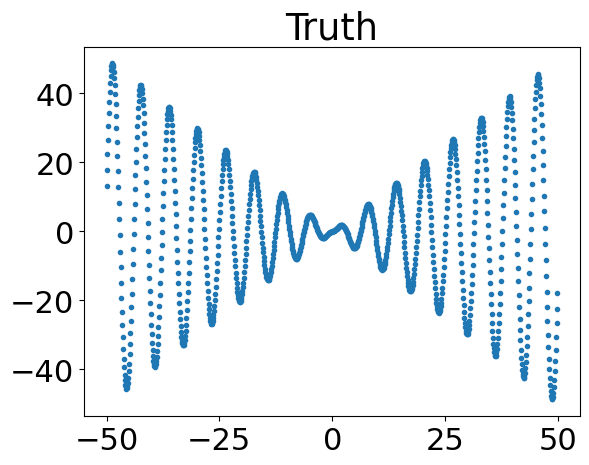

In [18]:
# X = np.arange(-50,50,0.1).reshape([-1,1])
# y = np.sin(X)*np.abs(X)
# ids = np.random.permutation(X.shape[0])
# np.savez('synthetic_data/amp_sine.npz',X=X, y=y, ids=ids)

tmp = np.load('synthetic_data/amp_sine.npz')
X = tmp['X']
y = tmp['y']
ids = tmp['ids']
teN = int(0.5*X.shape[0])
te_ids = ids[:teN]
tr_ids = ids[teN:]

te_ids = ids[:teN]
tr_ids = ids[teN:]
trX = X[tr_ids]
trY = y[tr_ids]
teX = X[te_ids]
teY = y[te_ids]
plt.figure()
# plt.plot(trX, trY, '.')
plt.plot(X, y, '.')
tr_pair_data = pair_dataset(trX, trY)
te_pair_data = pair_dataset(teX, teY)
BATCH_SIZE = 64
trainloader = torch.utils.data.DataLoader(dataset=tr_pair_data, batch_size=BATCH_SIZE, num_workers=0, shuffle=True, drop_last=True)
testloader = torch.utils.data.DataLoader(dataset=te_pair_data, batch_size=BATCH_SIZE, num_workers=0, shuffle=False, drop_last=False)
epochs = 1200
milestones = [300, 600, 900]
plt.title('Truth')
plt.savefig('./figures/pdfs/synthetic/amp_sin_truth.pdf',format='pdf')

In [ ]:
lr = 0.001
decay = 0


seeds = [1,2,3,4,5]
preds_GARM = []


for seed in seeds:
    set_all_seeds(seed)
    model = MLP_tri_head(input_dim=X.shape[-1], hidden_sizes=tuple([100]*3), num_classes=1)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=decay)
    scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=milestones, gamma=0.1)
    gar_mean = GAR_mean()
    for epoch in range(epochs):
        epoch_loss = 0 
        pred = []
        truth = []
        ratio = epoch/epochs
        for idx, data in enumerate(trainloader):
            optimizer.zero_grad()
            tr_X, tr_Y = data[0], data[1]
            pred_Y_mean, pred_Y_var, pred_Y_pearson, feat = model(tr_X)
            pred_Y = model.predict(pred_Y_mean, pred_Y_var, pred_Y_pearson)
            pred.append(pred_Y.cpu().detach().numpy())
            truth.append(tr_Y.cpu().detach().numpy())
            
               
            loss_mean = gar_mean(pred_Y_mean, tr_Y)
            loss_var = GAR_var(pred_Y_var, tr_Y)
            loss_pearson = GAR_pearson(pred_Y_pearson, tr_Y)
            loss_final = gar_mean(pred_Y, tr_Y) 
            loss = loss_mean + loss_var + loss_pearson + loss_final
            
            epoch_loss += loss.cpu().detach().numpy()
            loss.backward()
            optimizer.step()
        epoch_loss /= idx        
        if epoch % 10 == 0:
            pred = np.concatenate(pred, axis=0)
            truth = np.concatenate(truth, axis=0)
            tr_MAE = np.abs(pred-truth).mean()
            tr_RMSE = ((pred-truth)**2).mean()**0.5
            tr_pear = np.corrcoef(truth, pred, rowvar=False)[0,1]
            tr_spear = stats.spearmanr(truth, pred)
            print('Epoch=%s, train_MAE=%.4f, train_RMSE=%.4f, train_Pearson=%.4f, train_Spearman=%.4f, lr=%.4f'%(epoch, tr_MAE, tr_RMSE, tr_pear, tr_spear.statistic, scheduler.get_last_lr()[0]))
        pred = []
        truth = []
        if epoch % 10 == 0:
            for idx, data in enumerate(testloader):
                te_X, te_Y = data[0], data[1]
                pred_Y_mean, pred_Y_var, pred_Y_pearson, feat = model(te_X)
                pred_Y = model.predict(pred_Y_mean, pred_Y_var, pred_Y_pearson)
                pred.append(pred_Y.cpu().detach().numpy())
                truth.append(te_Y.cpu().detach().numpy())  
            pred = np.concatenate(pred, axis=0)
            truth = np.concatenate(truth, axis=0)
            test_MAE = np.abs(pred-truth).mean()
            test_RMSE = ((pred-truth)**2).mean()**0.5
            test_pear = np.corrcoef(truth, pred, rowvar=False)[0,1]
            test_spear = stats.spearmanr(truth, pred)
            print('test_MAE=%.4f, test_RMSE=%.4f, test_Pearson=%.4f, test_Spearman=%.4f'%(test_MAE, test_RMSE, test_pear, test_spear.statistic))
        scheduler.step()

    print(te_X.shape)
    print(torch.from_numpy(X).shape)
    pred_Y_mean, pred_Y_var, pred_Y_pearson, feat = model(torch.from_numpy(X).to(torch.float32))
    pred_Y = model.predict(pred_Y_mean, pred_Y_var, pred_Y_pearson)
    plt.figure()
    plt.plot(X, y, '.', label='truth')
    plt.plot(X, pred_Y.cpu().detach().numpy(), 'o', label='GARM')
    plt.legend()


    plt.figure()
    plt.plot(X, y/y.std(), label='truth')
    plt.legend()

    plt.figure()
    pred_Y = pred_Y.cpu().detach().numpy()
    plt.plot(X, pred_Y/pred_Y.std(), label='GARM')
    plt.legend()

    preds_GARM.append(pred_Y)
    
preds_GARM = np.concatenate(preds_GARM, axis=1)

In [ ]:
lr = 0.001
decay = 0


seeds = [1,2,3,4,5]
preds_GAR_1 = []

alpha = 1.0

for seed in seeds:
    set_all_seeds(seed)
    loss_GAR = GAR(alpha = alpha)
    model = FFNN(input_dim=X.shape[-1], hidden_sizes=tuple([100]*6), num_classes=1)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=decay)
    scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=milestones, gamma=0.1)

    for epoch in range(epochs):
        epoch_loss = 0 
        pred = []
        truth = []
        ratio = epoch/epochs
        for idx, data in enumerate(trainloader):
            optimizer.zero_grad()
            tr_X, tr_Y = data[0], data[1]
            pred_Y, _ = model(tr_X)
            pred.append(pred_Y.cpu().detach().numpy())
            truth.append(tr_Y.cpu().detach().numpy())
            
               
            loss = loss_GAR(pred_Y, tr_Y)
            
            epoch_loss += loss.cpu().detach().numpy()
            loss.backward()
            optimizer.step()
        epoch_loss /= idx
        if epoch % 10 == 0:
            pred = np.concatenate(pred, axis=0)
            truth = np.concatenate(truth, axis=0)
            tr_MAE = np.abs(pred-truth).mean()
            tr_RMSE = ((pred-truth)**2).mean()**0.5
            tr_pear = np.corrcoef(truth, pred, rowvar=False)[0,1]
            tr_spear = stats.spearmanr(truth, pred)
            print('Epoch=%s, train_MAE=%.4f, train_RMSE=%.4f, train_Pearson=%.4f, train_Spearman=%.4f, lr=%.4f'%(epoch, tr_MAE, tr_RMSE, tr_pear, tr_spear.statistic, scheduler.get_last_lr()[0]))
        pred = []
        truth = []
        for idx, data in enumerate(testloader):
            te_X, te_Y = data[0], data[1]
            pred_Y, _ = model(te_X)
            pred.append(pred_Y.cpu().detach().numpy())
            truth.append(te_Y.cpu().detach().numpy())
        if epoch % 10 == 0:
            pred = np.concatenate(pred, axis=0)
            truth = np.concatenate(truth, axis=0)
            test_MAE = np.abs(pred-truth).mean()
            test_RMSE = ((pred-truth)**2).mean()**0.5
            test_pear = np.corrcoef(truth, pred, rowvar=False)[0,1]
            test_spear = stats.spearmanr(truth, pred)
            print('test_MAE=%.4f, test_RMSE=%.4f, test_Pearson=%.4f, test_Spearman=%.4f'%(test_MAE, test_RMSE, test_pear, test_spear.statistic))
        scheduler.step()

    print(te_X.shape)
    print(torch.from_numpy(X).shape)
    pred_Y, _ = model(torch.from_numpy(X).to(torch.float32))
    plt.figure()
    plt.plot(X, y, '.', label='truth')
    plt.plot(X, pred_Y.cpu().detach().numpy(), 'o', label='GAR')
    plt.legend()


    plt.figure()
    plt.plot(X, y/y.std(), label='truth')
    plt.legend()

    plt.figure()
    pred_Y = pred_Y.cpu().detach().numpy()
    plt.plot(X, pred_Y/pred_Y.std(), label='GAR')
    plt.legend()

    preds_GAR_1.append(pred_Y)
    
preds_GAR_1 = np.concatenate(preds_GAR_1, axis=1)

In [ ]:
lr = 0.001
decay = 0


seeds = [1,2,3,4,5]
preds_GAR_2 = []

alpha = 10.0

for seed in seeds:
    set_all_seeds(seed)
    loss_GAR = GAR(alpha = alpha)
    model = FFNN(input_dim=X.shape[-1], hidden_sizes=tuple([100]*6), num_classes=1)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=decay)
    scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=milestones, gamma=0.1)

    for epoch in range(epochs):
        epoch_loss = 0 
        pred = []
        truth = []
        ratio = epoch/epochs
        for idx, data in enumerate(trainloader):
            optimizer.zero_grad()
            tr_X, tr_Y = data[0], data[1]
            pred_Y, _ = model(tr_X)
            pred.append(pred_Y.cpu().detach().numpy())
            truth.append(tr_Y.cpu().detach().numpy())
            
               
            loss = loss_GAR(pred_Y, tr_Y)
            
            epoch_loss += loss.cpu().detach().numpy()
            loss.backward()
            optimizer.step()
        epoch_loss /= idx
        if epoch % 10 == 0:
            pred = np.concatenate(pred, axis=0)
            truth = np.concatenate(truth, axis=0)
            tr_MAE = np.abs(pred-truth).mean()
            tr_RMSE = ((pred-truth)**2).mean()**0.5
            tr_pear = np.corrcoef(truth, pred, rowvar=False)[0,1]
            tr_spear = stats.spearmanr(truth, pred)
            print('Epoch=%s, train_MAE=%.4f, train_RMSE=%.4f, train_Pearson=%.4f, train_Spearman=%.4f, lr=%.4f'%(epoch, tr_MAE, tr_RMSE, tr_pear, tr_spear.statistic, scheduler.get_last_lr()[0]))
        pred = []
        truth = []
        for idx, data in enumerate(testloader):
            te_X, te_Y = data[0], data[1]
            pred_Y, _ = model(te_X)
            pred.append(pred_Y.cpu().detach().numpy())
            truth.append(te_Y.cpu().detach().numpy())
        if epoch % 10 == 0:
            pred = np.concatenate(pred, axis=0)
            truth = np.concatenate(truth, axis=0)
            test_MAE = np.abs(pred-truth).mean()
            test_RMSE = ((pred-truth)**2).mean()**0.5
            test_pear = np.corrcoef(truth, pred, rowvar=False)[0,1]
            test_spear = stats.spearmanr(truth, pred)
            print('test_MAE=%.4f, test_RMSE=%.4f, test_Pearson=%.4f, test_Spearman=%.4f'%(test_MAE, test_RMSE, test_pear, test_spear.statistic))
        scheduler.step()

    print(te_X.shape)
    print(torch.from_numpy(X).shape)
    pred_Y, _ = model(torch.from_numpy(X).to(torch.float32))
    plt.figure()
    plt.plot(X, y, '.', label='truth')
    plt.plot(X, pred_Y.cpu().detach().numpy(), 'o', label='GAR')
    plt.legend()


    plt.figure()
    plt.plot(X, y/y.std(), label='truth')
    plt.legend()

    plt.figure()
    pred_Y = pred_Y.cpu().detach().numpy()
    plt.plot(X, pred_Y/pred_Y.std(), label='GAR')
    plt.legend()

    preds_GAR_2.append(pred_Y)
    
preds_GAR_2 = np.concatenate(preds_GAR_2, axis=1)

In [ ]:
lr = 0.001
decay = 0


seeds = [1,2,3,4,5]
preds_GAR = []

alpha = 0.1

for seed in seeds:
    set_all_seeds(seed)
    loss_GAR = GAR(alpha = alpha)
    model = FFNN(input_dim=X.shape[-1], hidden_sizes=tuple([100]*6), num_classes=1)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=decay)
    scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=milestones, gamma=0.1)

    for epoch in range(epochs):
        epoch_loss = 0 
        pred = []
        truth = []
        ratio = epoch/epochs
        for idx, data in enumerate(trainloader):
            optimizer.zero_grad()
            tr_X, tr_Y = data[0], data[1]
            pred_Y, _ = model(tr_X)
            pred.append(pred_Y.cpu().detach().numpy())
            truth.append(tr_Y.cpu().detach().numpy())
            
               
            loss = loss_GAR(pred_Y, tr_Y)
            
            epoch_loss += loss.cpu().detach().numpy()
            loss.backward()
            optimizer.step()
        epoch_loss /= idx
        if epoch % 10 == 0:
            pred = np.concatenate(pred, axis=0)
            truth = np.concatenate(truth, axis=0)
            tr_MAE = np.abs(pred-truth).mean()
            tr_RMSE = ((pred-truth)**2).mean()**0.5
            tr_pear = np.corrcoef(truth, pred, rowvar=False)[0,1]
            tr_spear = stats.spearmanr(truth, pred)
            print('Epoch=%s, train_MAE=%.4f, train_RMSE=%.4f, train_Pearson=%.4f, train_Spearman=%.4f, lr=%.4f'%(epoch, tr_MAE, tr_RMSE, tr_pear, tr_spear.statistic, scheduler.get_last_lr()[0]))
        pred = []
        truth = []
        for idx, data in enumerate(testloader):
            te_X, te_Y = data[0], data[1]
            pred_Y, _ = model(te_X)
            pred.append(pred_Y.cpu().detach().numpy())
            truth.append(te_Y.cpu().detach().numpy())
        if epoch % 10 == 0:
            pred = np.concatenate(pred, axis=0)
            truth = np.concatenate(truth, axis=0)
            test_MAE = np.abs(pred-truth).mean()
            test_RMSE = ((pred-truth)**2).mean()**0.5
            test_pear = np.corrcoef(truth, pred, rowvar=False)[0,1]
            test_spear = stats.spearmanr(truth, pred)
            print('test_MAE=%.4f, test_RMSE=%.4f, test_Pearson=%.4f, test_Spearman=%.4f'%(test_MAE, test_RMSE, test_pear, test_spear.statistic))
        scheduler.step()

    print(te_X.shape)
    print(torch.from_numpy(X).shape)
    pred_Y, _ = model(torch.from_numpy(X).to(torch.float32))
    plt.figure()
    plt.plot(X, y, '.', label='truth')
    plt.plot(X, pred_Y.cpu().detach().numpy(), 'o', label='GAR')
    plt.legend()


    plt.figure()
    plt.plot(X, y/y.std(), label='truth')
    plt.legend()

    plt.figure()
    pred_Y = pred_Y.cpu().detach().numpy()
    plt.plot(X, pred_Y/pred_Y.std(), label='GAR')
    plt.legend()

    preds_GAR.append(pred_Y)
    
preds_GAR = np.concatenate(preds_GAR, axis=1)

In [ ]:
lr = 0.001
decay = 0
class pearson_loss(torch.nn.Module):
    def __init__(self, device = None):
        super().__init__()
        if not device:
            self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        else:
            self.device = device


    def forward(self, y_pred, y_truth):
        pred_std, truth_std = y_pred.std(dim=0), y_truth.std(dim=0)
        pred_mean, truth_mean = y_pred.mean(dim=0), y_truth.mean(dim=0)
        loss = ((y_pred-pred_mean)/pred_std - (y_truth-truth_mean)/truth_std)**2/2
        return loss.mean()


seeds = [1,2,3,4,5]
preds_Pearson = []

for seed in seeds:
    set_all_seeds(seed)
    loss_MAE = torch.nn.L1Loss()
    loss_pearson = pearson_loss()
    model = FFNN(input_dim=X.shape[-1], hidden_sizes=tuple([100]*6), num_classes=1)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=decay)
    scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=milestones, gamma=0.1)

    for epoch in range(epochs):
        epoch_loss = 0 
        pred = []
        truth = []
        ratio = epoch/epochs
        for idx, data in enumerate(trainloader):
            optimizer.zero_grad()
            tr_X, tr_Y = data[0], data[1]
            pred_Y, _ = model(tr_X)
            pred.append(pred_Y.cpu().detach().numpy())
            truth.append(tr_Y.cpu().detach().numpy())
            
            ploss = loss_pearson(pred_Y, tr_Y)
            beta = ploss.detach()/2
            loss = (1-beta)*loss_MAE(pred_Y, tr_Y) + beta*ploss
            epoch_loss += loss.cpu().detach().numpy()
            loss.backward()
            optimizer.step()
        epoch_loss /= idx
        if epoch % 10 == 0:
            pred = np.concatenate(pred, axis=0)
            truth = np.concatenate(truth, axis=0)
            tr_MAE = np.abs(pred-truth).mean()
            tr_RMSE = ((pred-truth)**2).mean()**0.5
            tr_pear = np.corrcoef(truth, pred, rowvar=False)[0,1]
            tr_spear = stats.spearmanr(truth, pred)
            print('Epoch=%s, train_MAE=%.4f, train_RMSE=%.4f, train_Pearson=%.4f, train_Spearman=%.4f, lr=%.4f'%(epoch, tr_MAE, tr_RMSE, tr_pear, tr_spear.statistic, scheduler.get_last_lr()[0]))
        pred = []
        truth = []
        for idx, data in enumerate(testloader):
            te_X, te_Y = data[0], data[1]
            pred_Y, _ = model(te_X)
            pred.append(pred_Y.cpu().detach().numpy())
            truth.append(te_Y.cpu().detach().numpy())
        if epoch % 10 == 0:
            pred = np.concatenate(pred, axis=0)
            truth = np.concatenate(truth, axis=0)
            test_MAE = np.abs(pred-truth).mean()
            test_RMSE = ((pred-truth)**2).mean()**0.5
            test_pear = np.corrcoef(truth, pred, rowvar=False)[0,1]
            test_spear = stats.spearmanr(truth, pred)
            print('test_MAE=%.4f, test_RMSE=%.4f, test_Pearson=%.4f, test_Spearman=%.4f'%(test_MAE, test_RMSE, test_pear, test_spear.statistic))
        scheduler.step()

    print(te_X.shape)
    print(torch.from_numpy(X).shape)
    pred_Y, _ = model(torch.from_numpy(X).to(torch.float32))
    plt.figure()
    plt.plot(X, y, '.', label='truth')
    plt.plot(X, pred_Y.cpu().detach().numpy(), 'o', label='MAE-Pearson')
    plt.legend()


    plt.figure()
    plt.plot(X, y/y.std(), label='truth')
    plt.legend()

    plt.figure()
    pred_Y = pred_Y.cpu().detach().numpy()
    plt.plot(X, pred_Y/pred_Y.std(), label='MAE-Pearson')
    plt.legend()

    preds_Pearson.append(pred_Y)
    
preds_Pearson = np.concatenate(preds_Pearson, axis=1)

In [ ]:
lr = 0.001
decay = 0

seeds = [1,2,3,4,5]
preds_MAE = []

for seed in seeds:
    set_all_seeds(seed)
    loss_MAE = torch.nn.L1Loss()
    model = FFNN(input_dim=X.shape[-1], hidden_sizes=tuple([100]*6), num_classes=1)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=decay)
    scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=milestones, gamma=0.1)

    for epoch in range(epochs):
        epoch_loss = 0 
        pred = []
        truth = []
        ratio = epoch/epochs
        for idx, data in enumerate(trainloader):
            optimizer.zero_grad()
            tr_X, tr_Y = data[0], data[1]
            pred_Y, _ = model(tr_X)
            pred.append(pred_Y.cpu().detach().numpy())
            truth.append(tr_Y.cpu().detach().numpy())
            
            loss = loss_MAE(pred_Y, tr_Y)
            
            epoch_loss += loss.cpu().detach().numpy()
            loss.backward()
            optimizer.step()
        epoch_loss /= idx
        if epoch % 10 == 0:
            pred = np.concatenate(pred, axis=0)
            truth = np.concatenate(truth, axis=0)
            tr_MAE = np.abs(pred-truth).mean()
            tr_RMSE = ((pred-truth)**2).mean()**0.5
            tr_pear = np.corrcoef(truth, pred, rowvar=False)[0,1]
            tr_spear = stats.spearmanr(truth, pred)
            print('Epoch=%s, train_MAE=%.4f, train_RMSE=%.4f, train_Pearson=%.4f, train_Spearman=%.4f, lr=%.4f'%(epoch, tr_MAE, tr_RMSE, tr_pear, tr_spear.statistic, scheduler.get_last_lr()[0]))
        pred = []
        truth = []
        for idx, data in enumerate(testloader):
            te_X, te_Y = data[0], data[1]
            pred_Y, _ = model(te_X)
            pred.append(pred_Y.cpu().detach().numpy())
            truth.append(te_Y.cpu().detach().numpy())
        if epoch % 10 == 0:
            pred = np.concatenate(pred, axis=0)
            truth = np.concatenate(truth, axis=0)
            test_MAE = np.abs(pred-truth).mean()
            test_RMSE = ((pred-truth)**2).mean()**0.5
            test_pear = np.corrcoef(truth, pred, rowvar=False)[0,1]
            test_spear = stats.spearmanr(truth, pred)
            print('test_MAE=%.4f, test_RMSE=%.4f, test_Pearson=%.4f, test_Spearman=%.4f'%(test_MAE, test_RMSE, test_pear, test_spear.statistic))
        scheduler.step()

    print(te_X.shape)
    print(torch.from_numpy(X).shape)
    pred_Y, _ = model(torch.from_numpy(X).to(torch.float32))
    plt.figure()
    plt.plot(X, y, '.', label='truth')
    plt.plot(X, pred_Y.cpu().detach().numpy(), 'o', label='MAE')
    plt.legend()


    plt.figure()
    plt.plot(X, y/y.std(), label='truth')
    plt.legend()

    plt.figure()
    pred_Y = pred_Y.cpu().detach().numpy()
    plt.plot(X, pred_Y/pred_Y.std(), label='MAE')
    plt.legend()

    preds_MAE.append(pred_Y)
    
preds_MAE = np.concatenate(preds_MAE, axis=1)

In [ ]:
lr = 0.001
decay = 0

seeds = [1,2,3,4,5]
preds_MSE = []

for seed in seeds:
    set_all_seeds(seed)
    loss_MSE = torch.nn.MSELoss()
    model = FFNN(input_dim=X.shape[-1], hidden_sizes=tuple([100]*6), num_classes=1)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=decay)
    scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=milestones, gamma=0.1)

    for epoch in range(epochs):
        epoch_loss = 0 
        pred = []
        truth = []
        ratio = epoch/epochs
        for idx, data in enumerate(trainloader):
            optimizer.zero_grad()
            tr_X, tr_Y = data[0], data[1]
            pred_Y, _ = model(tr_X)
            pred.append(pred_Y.cpu().detach().numpy())
            truth.append(tr_Y.cpu().detach().numpy())
            
            loss = loss_MSE(pred_Y, tr_Y)
            
            epoch_loss += loss.cpu().detach().numpy()
            loss.backward()
            optimizer.step()
        epoch_loss /= idx
        if epoch % 10 == 0:
            pred = np.concatenate(pred, axis=0)
            truth = np.concatenate(truth, axis=0)
            tr_MAE = np.abs(pred-truth).mean()
            tr_RMSE = ((pred-truth)**2).mean()**0.5
            tr_pear = np.corrcoef(truth, pred, rowvar=False)[0,1]
            tr_spear = stats.spearmanr(truth, pred)
            print('Epoch=%s, train_MAE=%.4f, train_RMSE=%.4f, train_Pearson=%.4f, train_Spearman=%.4f, lr=%.4f'%(epoch, tr_MAE, tr_RMSE, tr_pear, tr_spear.statistic, scheduler.get_last_lr()[0]))
        pred = []
        truth = []
        for idx, data in enumerate(testloader):
            te_X, te_Y = data[0], data[1]
            pred_Y, _ = model(te_X)
            pred.append(pred_Y.cpu().detach().numpy())
            truth.append(te_Y.cpu().detach().numpy())
        if epoch % 10 == 0:
            pred = np.concatenate(pred, axis=0)
            truth = np.concatenate(truth, axis=0)
            test_MAE = np.abs(pred-truth).mean()
            test_RMSE = ((pred-truth)**2).mean()**0.5
            test_pear = np.corrcoef(truth, pred, rowvar=False)[0,1]
            test_spear = stats.spearmanr(truth, pred)
            print('test_MAE=%.4f, test_RMSE=%.4f, test_Pearson=%.4f, test_Spearman=%.4f'%(test_MAE, test_RMSE, test_pear, test_spear.statistic))
        scheduler.step()

    print(te_X.shape)
    print(torch.from_numpy(X).shape)
    pred_Y, _ = model(torch.from_numpy(X).to(torch.float32))
    plt.figure()
    plt.plot(X, y, '.', label='truth')
    plt.plot(X, pred_Y.cpu().detach().numpy(), 'o', label='MSE')
    plt.legend()


    plt.figure()
    plt.plot(X, y/y.std(), label='truth')
    plt.legend()

    plt.figure()
    pred_Y = pred_Y.cpu().detach().numpy()
    plt.plot(X, pred_Y/pred_Y.std(), label='MSE')
    plt.legend()

    preds_MSE.append(pred_Y)
    
preds_MSE = np.concatenate(preds_MSE, axis=1)

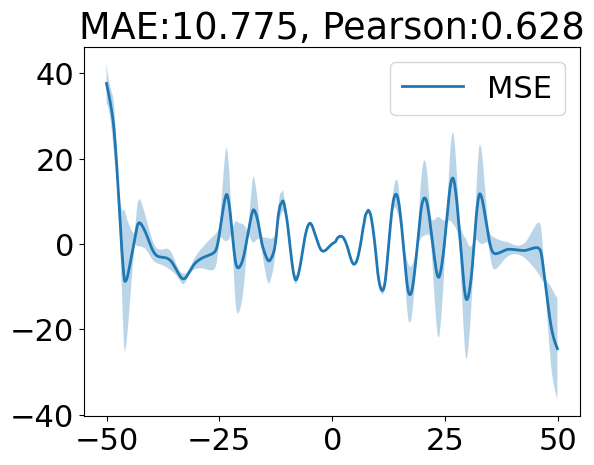

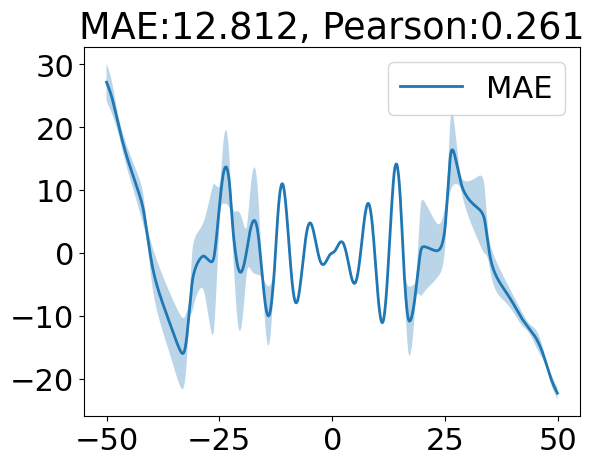

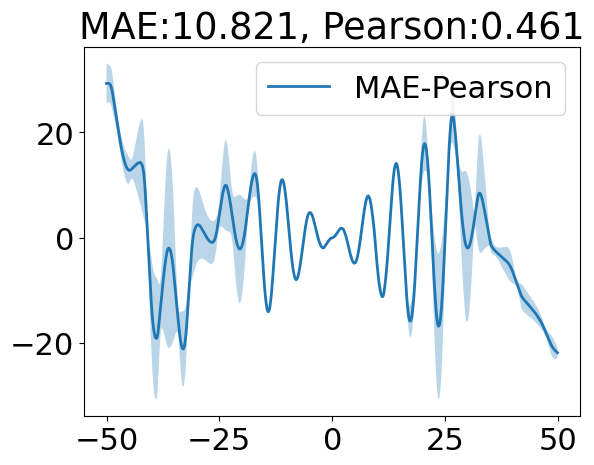

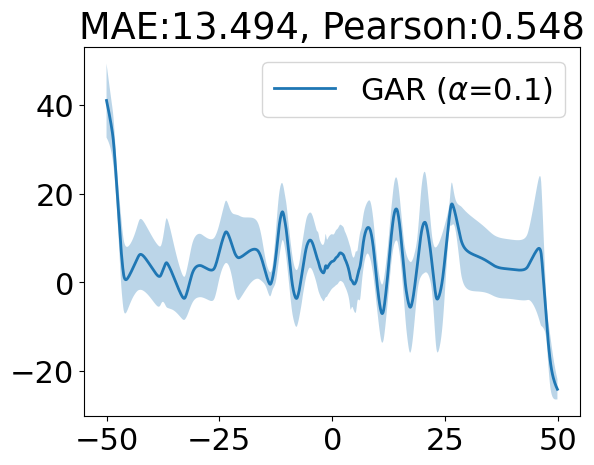

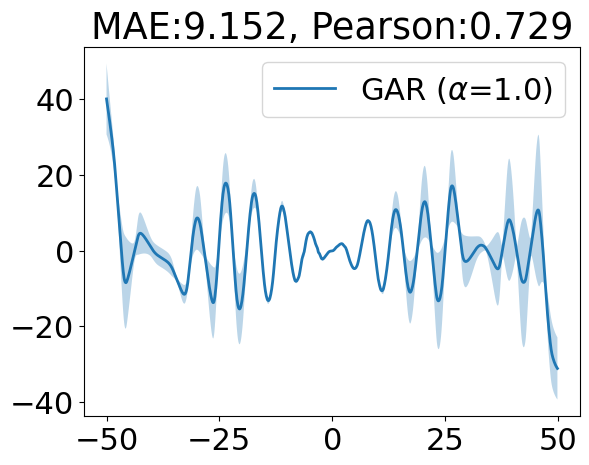

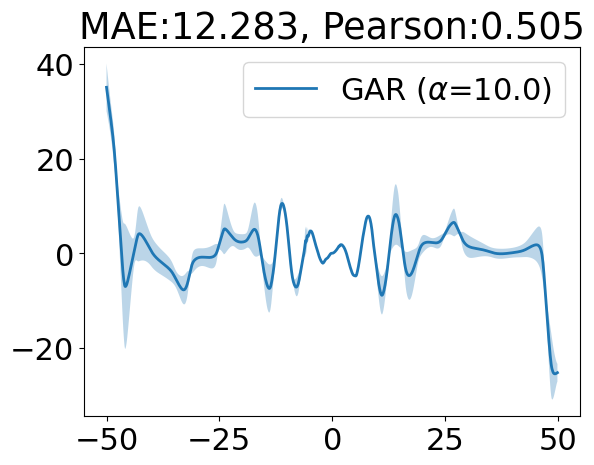

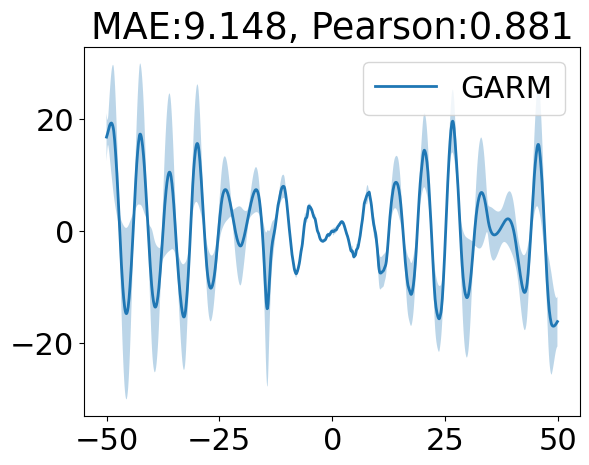

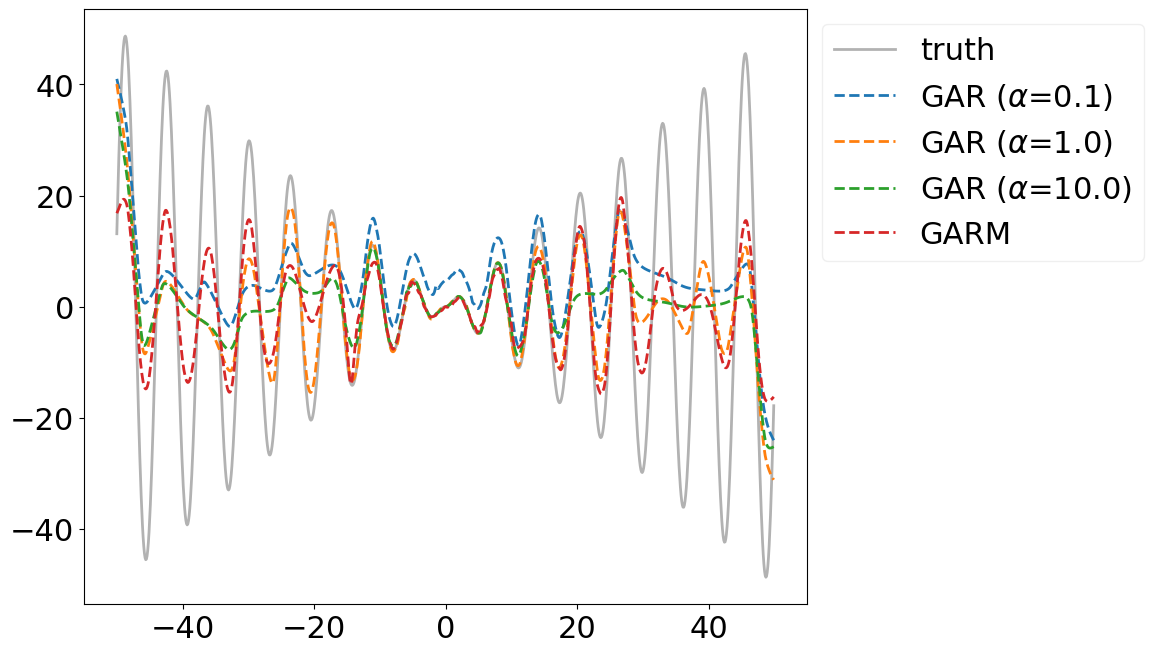

In [26]:

mean_MSE = preds_MSE.mean(axis=1)
std_MSE = preds_MSE.std(axis=1)
mae = np.abs(mean_MSE[te_ids] - np.squeeze(y)[te_ids]).mean()
pear = np.corrcoef(np.squeeze(y)[te_ids], mean_MSE[te_ids], rowvar=False)[0,1]
plt.figure()
plt.plot(X.squeeze(), mean_MSE, label='MSE')
plt.fill_between(X.squeeze(),mean_MSE-std_MSE, mean_MSE+std_MSE, alpha=0.3)
plt.title('MAE:'+str(np.round(mae, 3))+', Pearson:'+str(np.round(pear, 3)))
plt.legend()
plt.savefig('./figures/pdfs/synthetic/amp_sin_MSE.pdf',format='pdf')


mean_MAE = preds_MAE.mean(axis=1)
std_MAE = preds_MAE.std(axis=1)
mae = np.abs(mean_MAE[te_ids] - np.squeeze(y)[te_ids]).mean()
pear = np.corrcoef(np.squeeze(y)[te_ids], mean_MAE[te_ids], rowvar=False)[0,1]
plt.figure()
plt.plot(X.squeeze(), mean_MAE, label='MAE')
plt.fill_between(X.squeeze(),mean_MAE-std_MAE, mean_MAE+std_MAE, alpha=0.3)
plt.title('MAE:'+str(np.round(mae, 3))+', Pearson:'+str(np.round(pear, 3)))
plt.legend()
plt.savefig('./figures/pdfs/synthetic/amp_sin_MAE.pdf',format='pdf')


mean_APearson = preds_Pearson.mean(axis=1)
std_APearson = preds_Pearson.std(axis=1)
mae = np.abs(mean_APearson[te_ids] - np.squeeze(y)[te_ids]).mean()
pear = np.corrcoef(np.squeeze(y)[te_ids], mean_APearson[te_ids], rowvar=False)[0,1]
plt.figure()
plt.plot(X.squeeze(), mean_APearson, label='MAE-Pearson')
plt.fill_between(X.squeeze(),mean_APearson-std_APearson, mean_APearson+std_APearson, alpha=0.3)
plt.title('MAE:'+str(np.round(mae, 3))+', Pearson:'+str(np.round(pear, 3)))
plt.legend()
plt.savefig('./figures/pdfs/synthetic/amp_sin_APearson.pdf',format='pdf')



mean_GAR = preds_GAR.mean(axis=1)
std_GAR = preds_GAR.std(axis=1)
mae = np.abs(mean_GAR[te_ids] - np.squeeze(y)[te_ids]).mean()
pear = np.corrcoef(np.squeeze(y)[te_ids], mean_GAR[te_ids], rowvar=False)[0,1]
plt.figure()
plt.plot(X.squeeze(), mean_GAR, label=r'GAR ($\alpha$=0.1)')
plt.fill_between(X.squeeze(),mean_GAR-std_GAR, mean_GAR+std_GAR, alpha=0.3)
plt.title('MAE:'+str(np.round(mae, 3))+', Pearson:'+str(np.round(pear, 3)))
plt.legend()
plt.savefig('./figures/pdfs/synthetic/amp_sin_GAR_01.pdf',format='pdf')


mean_GAR_1 = preds_GAR_1.mean(axis=1)
std_GAR_1 = preds_GAR_1.std(axis=1)
mae = np.abs(mean_GAR_1[te_ids] - np.squeeze(y)[te_ids]).mean()
pear = np.corrcoef(np.squeeze(y)[te_ids], mean_GAR_1[te_ids], rowvar=False)[0,1]
plt.figure()
plt.plot(X.squeeze(), mean_GAR_1, label=r'GAR ($\alpha$=1.0)')
plt.fill_between(X.squeeze(),mean_GAR_1-std_GAR_1, mean_GAR_1+std_GAR_1, alpha=0.3)
plt.title('MAE:'+str(np.round(mae, 3))+', Pearson:'+str(np.round(pear, 3)))
plt.legend()
plt.savefig('./figures/pdfs/synthetic/amp_sin_GAR_1.pdf',format='pdf')


mean_GAR_2 = preds_GAR_2.mean(axis=1)
std_GAR_2 = preds_GAR_2.std(axis=1)
mae = np.abs(mean_GAR_2[te_ids] - np.squeeze(y)[te_ids]).mean()
pear = np.corrcoef(np.squeeze(y)[te_ids], mean_GAR_2[te_ids], rowvar=False)[0,1]
plt.figure()
plt.plot(X.squeeze(), mean_GAR_2, label=r'GAR ($\alpha$=10.0)')
plt.fill_between(X.squeeze(),mean_GAR_2-std_GAR_2, mean_GAR_2+std_GAR_2, alpha=0.3)
plt.title('MAE:'+str(np.round(mae, 3))+', Pearson:'+str(np.round(pear, 3)))
plt.legend()
plt.savefig('./figures/pdfs/synthetic/amp_sin_GAR_10.pdf',format='pdf')


mean_GARM = preds_GARM.mean(axis=1)
std_GARM = preds_GARM.std(axis=1)
mae = np.abs(mean_GARM[te_ids] - np.squeeze(y)[te_ids]).mean()
pear = np.corrcoef(np.squeeze(y)[te_ids], mean_GARM[te_ids], rowvar=False)[0,1]
plt.figure()
plt.plot(X.squeeze(), mean_GARM, label='GARM')
plt.fill_between(X.squeeze(),mean_GARM-std_GARM, mean_GARM+std_GARM, alpha=0.3)
plt.title('MAE:'+str(np.round(mae, 3))+', Pearson:'+str(np.round(pear, 3)))
plt.legend()
plt.savefig('./figures/pdfs/synthetic/amp_sin_GARM.pdf',format='pdf')


plt.figure(figsize=(12,7))
plt.plot(X, y, 'k-', alpha=0.3, label='truth')
plt.plot(X.squeeze(), mean_GAR, '--', label=r'GAR ($\alpha$=0.1)')
plt.plot(X.squeeze(), mean_GAR_1, '--', label=r'GAR ($\alpha$=1.0)')
plt.plot(X.squeeze(), mean_GAR_2, '--', label=r'GAR ($\alpha$=10.0)')
plt.plot(X.squeeze(), mean_GARM, '--', label='GARM')
plt.legend(fancybox=True, framealpha=0.3, bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.savefig('./figures/pdfs/synthetic/amp_sin_all_mean_cmp_GAR.pdf',format='pdf')

In [27]:
# np.savez('backups/amp_sin_preds.npz', preds_MSE=preds_MSE, preds_MAE=preds_MAE, preds_Pearson=preds_Pearson, preds_GAR=preds_GAR, preds_GAR_1=preds_GAR_1, preds_GAR_2=preds_GAR_2, preds_GARM=preds_GARM)